In [2]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

In [3]:
from flamingchoripan.files import search_for_filedirs
from lchandler import C_

root_folder = '../../surveys-save'
filedirs = search_for_filedirs(root_folder, fext=C_.EXT_SPLIT_LIGHTCURVE)

────────────────────────────────────────────────────────────────────────────────────────────────────
found filedirs: (../../surveys-save)
(0) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=linear.splcds - 59.599[mbs]
(1) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe.splcds - 4.557[mbs]
(2) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=curvefit.splcds - 59.532[mbs]
(3) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=bspline.splcds - 59.600[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────
filedirs after searching with filters: (../../surveys-save)
(0) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=linear.splcds - 59.599[mbs]
(1) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe.splcds - 4.557[mbs]
(2) - ../../surveys-save/a

In [4]:
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir
from lchandler import C_

def load_lcdataset(filename):
    assert filename.split('.')[-1]==C_.EXT_SPLIT_LIGHTCURVE
    return load_pickle(filename)

filedir = f'../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe.splcds'

filedict = get_dict_from_filedir(filedir)
root_folder = filedict['*rootdir*']
cfilename = filedict['*cfilename*']
survey = filedict['survey']
lcdataset = load_lcdataset(filedir)
print(lcdataset['raw'].keys())
print(lcdataset['raw'].get_random_lcobj(False).keys())
print(lcdataset)

> loading: ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe.splcds
dict_keys(['data', 'survey', 'description', 'band_names', 'class_names', 'obs_is_flux'])
dict_keys(['days', 'obs', 'obse', 'y', 'synthetic'])
LCDataset:
[outliers - samples 10]
(*) obs_samples: 541 - min_len: 14 - max_dur: 408.0[days] - dur(p50): 133.8[days] - cadence(p50): 1.0[days]
(g) obs_samples: 260 - min_len: 6 - max_dur: 408.0[days] - dur(p50): 133.8[days] - cadence(p50): 3.0[days]
(r) obs_samples: 281 - min_len: 8 - max_dur: 376.0[days] - dur(p50): 128.7[days] - cadence(p50): 3.0[days]
   |█▌      | SLSN - 2/10 (20.00%)
   |▊       | SNIa - 1/10 (10.00%)
   |█▌      | SNIbc - 2/10 (20.00%)
   |████    | allSNII - 5/10 (50.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint - samples 48]
(*) obs_samples: 1,107 - min_len: 7 - max_dur: 298.1[days] - dur(p50): 40.5[days] - cadence(p50): 1.0[days]
(g) obs_samples: 450 - min_len: 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
> loading: ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=curvefit.splcds
100%|██████████| 100/100 [03:04,  1.84s/it, training id: 99 - samples: 74432 - features: 18]


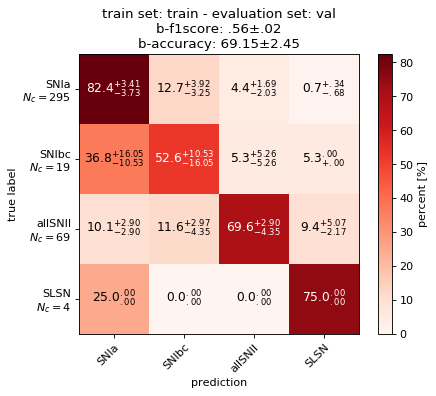

100%|██████████| 100/100 [03:04,  1.85s/it, training id: 99 - samples: 74432 - features: 18]


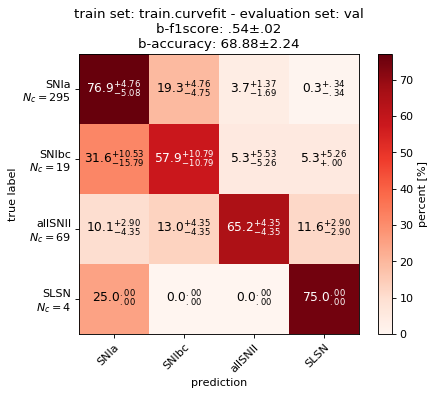

 68%|██████▊   | 68/100 [02:08,  2.01s/it, training id: 67 - samples: 74432 - features: 18]

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir
from lchandler import C_
from lcfats.classifiers import get_fitted_classifiers, evaluate_classifiers
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
from flamingchoripan.datascience.statistics import XError
import matplotlib.pyplot as plt

max_model_ids = 100
test_lcset_name = 'val' # val test
methods = ['curvefit', 'bspline', 'linear']
#methods = ['linear']
for method in methods:
    new_cfilename = f'{cfilename}°method={method}'
    filedir = f'{root_folder}/{new_cfilename}.{C_.EXT_SPLIT_LIGHTCURVE}'
    lcdataset = load_lcdataset(filedir)
    #print(lcdataset);assert 0
    rf_results = {}
    train_configs = [
        ('train', False),
        (f'train.{method}', False),
        (f'train.{method}', True),
    ]
    for (train_lcset_name,add_real_samples) in train_configs:
        load_rootdir = f'../save/{survey}/{new_cfilename}/features'
        fit_kwargs = {
            'max_model_ids':max_model_ids,
            'add_real_samples':add_real_samples,
        }
        classifier_dict, model_ids = get_fitted_classifiers(lcdataset, train_lcset_name, load_rootdir, **fit_kwargs)
        train_lcset_name = f'{train_lcset_name}{"+real" if add_real_samples else ""}'
        rf_results[train_lcset_name] = evaluate_classifiers(lcdataset, test_lcset_name, classifier_dict, model_ids, load_rootdir)
        
        ### plot cms
        d = rf_results[train_lcset_name]
        lcset_name = d[model_ids[0]]['lcset_name']
        class_names = d[model_ids[0]]['class_names']
        cms = [d[id]['cm'][None] for id in model_ids]
        f1score_xe = XError([d[id]['metrics_dict']['b-f1score'] for id in model_ids])
        accuracy_xe = XError([d[id]['metrics_dict']['b-accuracy'] for id in model_ids])
        title = f'train set: {train_lcset_name} - evaluation set: {lcset_name}\n'
        title += f'b-f1score: {f1score_xe}\n'
        title += f'b-accuracy: {accuracy_xe}'
        cm_kwargs = {
            'title':title,
            'figsize':(6,5),
            'new_order_classes':['SNIa', 'SNIbc', 'allSNII', 'SLSN'],
        }
        fig, ax = plot_custom_confusion_matrix(np.concatenate(cms, axis=0), class_names, **cm_kwargs)
        plt.show()
        
    save_filedir = f'../save/{survey}/{new_cfilename}/rf.res'
    save_pickle(save_filedir, rf_results)

In [248]:
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.statistics import XError
from flamingchoripan.latex.latex_tables import LatexTable
import pandas as pd

methods = ['bspline', 'linear', 'curvefit']
#methods = ['curvefit']
n_decimals = 3
info_dict = {}
for km,method in enumerate(methods):
    new_cfilename = f'{cfilename}°method={method}'
    load_filedir = f'../save/{survey}/{new_cfilename}/rf.res'
    rf_results = load_pickle(load_filedir)
    model_ids = list(rf_results['train'].keys())
    d = {}
    for m in ['b-accuracy', 'b-f1score', 'b-gmean', 'b-dpower']:
        if km==0:
            info_dict[f'metric={m} [real]'] = {}
            info_dict[f'metric={m} [synth]'] = {}
            info_dict[f'metric={m} [synth+real]'] = {}
        info_dict[f'metric={m} [real]'][method] = XError([rf_results[f'train'][id]['metrics_dict'][m] for id in model_ids], n_decimals=n_decimals)
        info_dict[f'metric={m} [synth]'][method] = XError([rf_results[f'train.{method}'][id]['metrics_dict'][m] for id in model_ids], n_decimals=n_decimals)
        info_dict[f'metric={m} [synth+real]'][method] = XError([rf_results[f'train.{method}+real'][id]['metrics_dict'][m] for id in model_ids], n_decimals=n_decimals)
    
info_df = pd.DataFrame.from_dict(info_dict, orient='index').reindex(list(info_dict.keys()))

latex_kwargs = {
    'caption':'$x_j$',
    'label':'???',
    'bold_criteriums':'max',
    #'custom_tabular_align':'l|cc|cc|cc',
}
latex_table = LatexTable(info_df, **latex_kwargs)
print(latex_table)
info_df

> loading: ../save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=bspline/rf.res
> loading: ../save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=linear/rf.res
> loading: ../save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=curvefit/rf.res
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{$x_j$}
\label{???}\vspace{.1cm}
\begin{tabular}{l|ccc}
\hline
metric & bspline & linear & curvefit \srule\\\hline\hline
b-accuracy [real] & \textbf{68.049$\pm$2.166} & 67.457$\pm$2.390 & 67.913$\pm$1.781  \srule\\
b-accuracy [synth] & 59.929$\pm$3.340 & 67.085$\pm$2.351 & 67.158$\pm$2.565  \srule\\
b-accuracy [synth+real] & 66.130$\pm$1.939 & \textbf{68.204$\pm$1.276} & \textbf{68.227$\pm$2.918}  \srule\\
b-f1score [real] & .547$\pm$.026 & .549$\pm$.021 & .553$\pm$.014  \srule\\
b-f1score [synth] & .460$\pm$.025 & .

,bspline,linear,curvefit
metric=b-accuracy [real],68.049±2.166,67.457±2.390,67.913±1.781
metric=b-accuracy [synth],59.929±3.340,67.085±2.351,67.158±2.565
metric=b-accuracy [synth+real],66.130±1.939,68.204±1.276,68.227±2.918
metric=b-f1score [real],.547±.026,.549±.021,.553±.014
metric=b-f1score [synth],.460±.025,.537±.010,.518±.023
metric=b-f1score [synth+real],.516±.020,.539±.020,.538±.020
metric=b-gmean [real],.780±.016,.776±.019,.778±.015
metric=b-gmean [synth],.711±.025,.772±.017,.774±.017
metric=b-gmean [synth+real],.764±.014,.782±.010,.781±.020
metric=b-dpower [real],1.858±.101,1.856±.105,1.861±.068


In [180]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.statistics import XError
from flamingchoripan.latex.latex_tables import LatexTable
import pandas as pd

methods = ['linear', 'mcmc', 'curvefit', 'bspline']
methods = ['curvefit']
info_dict = {}
for km,method in enumerate(methods):
    new_cfilename = f'{cfilename}°method={method}'
    load_filedir = f'../save/{survey}/{new_cfilename}/rf.res'
    rf_results = load_pickle(load_filedir)
    model_ids = list(rf_results['train'].keys())
    rank = rf_results[f'train.{method}'][model_ids[0]]['rank']
    features = rf_results[f'train.{method}'][model_ids[0]]['features']
    print(len(features), features)
    rank.print_n = 20
    rank.values = [v*100 for v in rank.values]
    rank.name = f'rf-importance[%] [{method}]'
    df = rank.get_df()
    df.index = [f'feature={i.replace("_", "-")}' for i in list(df.index)]
    info_dict[method] = df
    break
info_df = info_dict[method]
    
latex_kwargs = {
    'caption':'$x_j$',
    'label':'???',
}
latex_table = LatexTable(info_df, **latex_kwargs)
print(latex_table)
info_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
> loading: ../save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=curvefit/rf.res
94 ['CAR_sigma_g', 'CAR_mean_g', 'CAR_tau_g', 'FluxPercentileRatioMid20_g', 'FluxPercentileRatioMid35_g', 'FluxPercentileRatioMid50_g', 'FluxPercentileRatioMid65_g', 'FluxPercentileRatioMid80_g', 'PercentDifferenceFluxPercentile_g', 'Amplitude_g', 'AndersonDarling_g', 'Autocor_length_g', 'Beyond1Std_g', 'Con_g', 'Eta_e_g', 'ExcessVar_g', 'Gskew_g', 'IAR_phi_g', 'LinearTrend_g', 'MaxSlope_g', 'Mean_g', 'Meanvariance_g', 'MedianAbsDev_g', 'MedianBRP_g', 'PairSlopeTrend_g', 'PercentAmplitude_g', 'Pvar_g', 'Q31_g', 'Rcs_g', 'SF_ML_amplitude_g', 'SF_ML_gamma_g', 'Skew_g', 'SmallKurtosis_g', 'Std_g', 'StetsonK_g', 'SPM_A_g', 'SPM_t0_g', 'SPM_gamma_g', 'SPM_beta_g', 'SPM_tau_rise_g', 'SPM_tau_fall_g', 'SPM_chi_g', 'MHPS_ratio_g', 'MHPS_low_g', 'MHPS_high_g', 'MHPS_non_zero_g', 'MHPS_PN_flag_g', 'CAR_sigma_r',

,k,rf-importance[%] [curvefit]
feature=SPM-gamma-r,1,4.242142
feature=SPM-t0-r,2,3.646047
feature=SPM-t0-g,3,3.601850
feature=SPM-tau-rise-r,4,3.565943
feature=LinearTrend-g,5,3.392942
feature=SPM-gamma-g,6,2.752964
feature=CAR-sigma-r,7,2.460815
feature=IAR-phi-g,8,2.453055
feature=SPM-tau-fall-r,9,2.246822
feature=SPM-tau-fall-g,10,2.209982
